In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as layers

In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from flows import NVPFlow, FlowSequence, ResFlow, BNFlow, phase

In [3]:
inp = tf.placeholder(tf.float32, [None, 2])

In [4]:
flow = NVPFlow(2, 'init_flow', inp)

for i in range(0, 16):
    flow = NVPFlow(name='dense_' + str(i))(flow)
    flow = ResFlow(name='res_' + str(i))(flow)
    flow = BNFlow(name='bn_' + str(i))(flow)

In [5]:
flow[-1].output /= 8

In [6]:
flow[-1].logj.shape

TensorShape([])

In [7]:
flows = FlowSequence(flow[1:])

In [8]:
logj = flows.calc_logj()

In [9]:
logj

<tf.Tensor 'add_47:0' shape=(?,) dtype=float32>

In [10]:
z = flows[-1].output
gain = tf.reduce_sum(-(z**2)/2, axis=-1) + logj
gain = tf.reduce_mean(gain)

In [11]:
z

<tf.Tensor 'truediv:0' shape=(?, 2) dtype=float32>

In [12]:
train_op = tf.train.AdamOptimizer(0.001).minimize(-gain)
train_op = [train_op] + flows.ops

In [25]:
X, _ = make_moons(n_samples=1024, noise=0.13)

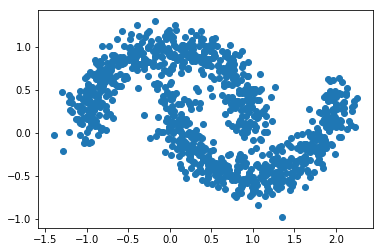

In [14]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [15]:
sess = tf.InteractiveSession()

In [16]:
tf.global_variables_initializer().run()

In [17]:
logj.eval({inp:X, phase: False}).mean()

-14.446419

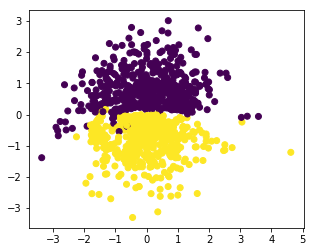

In [27]:
X, y = make_moons(n_samples=1024, noise=0.13)
ver = z.eval({inp:X})

ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(ver[:,0], ver[:,1], c=y)
plt.show()

In [23]:
for _ in range(1000):
    for _ in range(1000):
        X, _ = make_moons(n_samples=256, noise=0.13)
        sess.run(train_op, {inp:X})
    print(gain.eval({inp:X}).mean())

-6.91802
-6.75722
-6.67539
-6.64719
-6.58507
-6.58743
-6.56672
-6.57654
-6.43866
-6.65601
-6.54988
-6.62342
-6.47561
-6.5269
-6.49183
-6.53183
-6.44458
-6.44265
-6.49947
-6.52908
-6.54092


KeyboardInterrupt: 

In [28]:
inverse = flows.apply(inp*8, inverse=True)

In [29]:
restored = inverse.eval({inp:np.random.normal(size=[400,2]), phase: False})
#restored = inverse.eval({inp:ver})

In [30]:
restored = restored[np.logical_not(np.any(restored**2 > 10, axis=-1))]

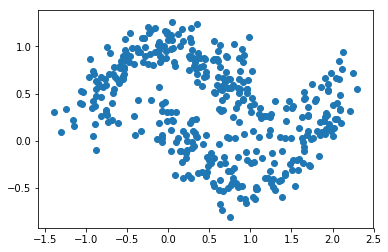

In [31]:
plt.scatter(restored[:,0], restored[:,1])
plt.show()